# Question 1

In [76]:
import tensorflow as tf
import pathlib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## 讀取資料集

In [77]:
PATH_TO_DATASET_FOLDER = pathlib.Path("HW4_MNIST_train/4")
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WEIDTH = 128

TRAINING_RATIO = 0.8
TESTING_RATIO = 0.1
VALIDATION_RATIO = 1 - TRAINING_RATIO - TESTING_RATIO

assert VALIDATION_RATIO >= 0

list_ds = tf.data.Dataset.list_files(str(PATH_TO_DATASET_FOLDER/"*.png"))

def process_file(file_path):
    bounding_box_info_file = tf.strings.join([
        tf.strings.substr(file_path, 0, tf.strings.length(file_path)-len(".png")),
        ".txt"
    ])
    infos = tf.strings.split(tf.io.read_file(bounding_box_info_file), '\t')
    infos = tf.map_fn(lambda x:tf.strings.to_number(x, tf.float32), infos, tf.float32)

    image = tf.io.decode_png(
        tf.io.read_file(file_path),
        channels=1
    )

    classification = tf.one_hot(tf.cast(infos[0], tf.int32), depth=10)

    return image, (classification, infos[1], infos[2], infos[3], infos[4])


list_ds = list_ds.map(process_file)

train_size = int(TRAINING_RATIO * len(list_ds))
test_size = int(TESTING_RATIO * len(list_ds))

train_ds = list_ds.take(train_size).batch(BATCH_SIZE)
test_ds = list_ds.skip(train_size).take(test_size).batch(BATCH_SIZE)
valid_ds = list_ds.skip(train_size).skip(test_size).batch(BATCH_SIZE)

## 建構與訓練模型

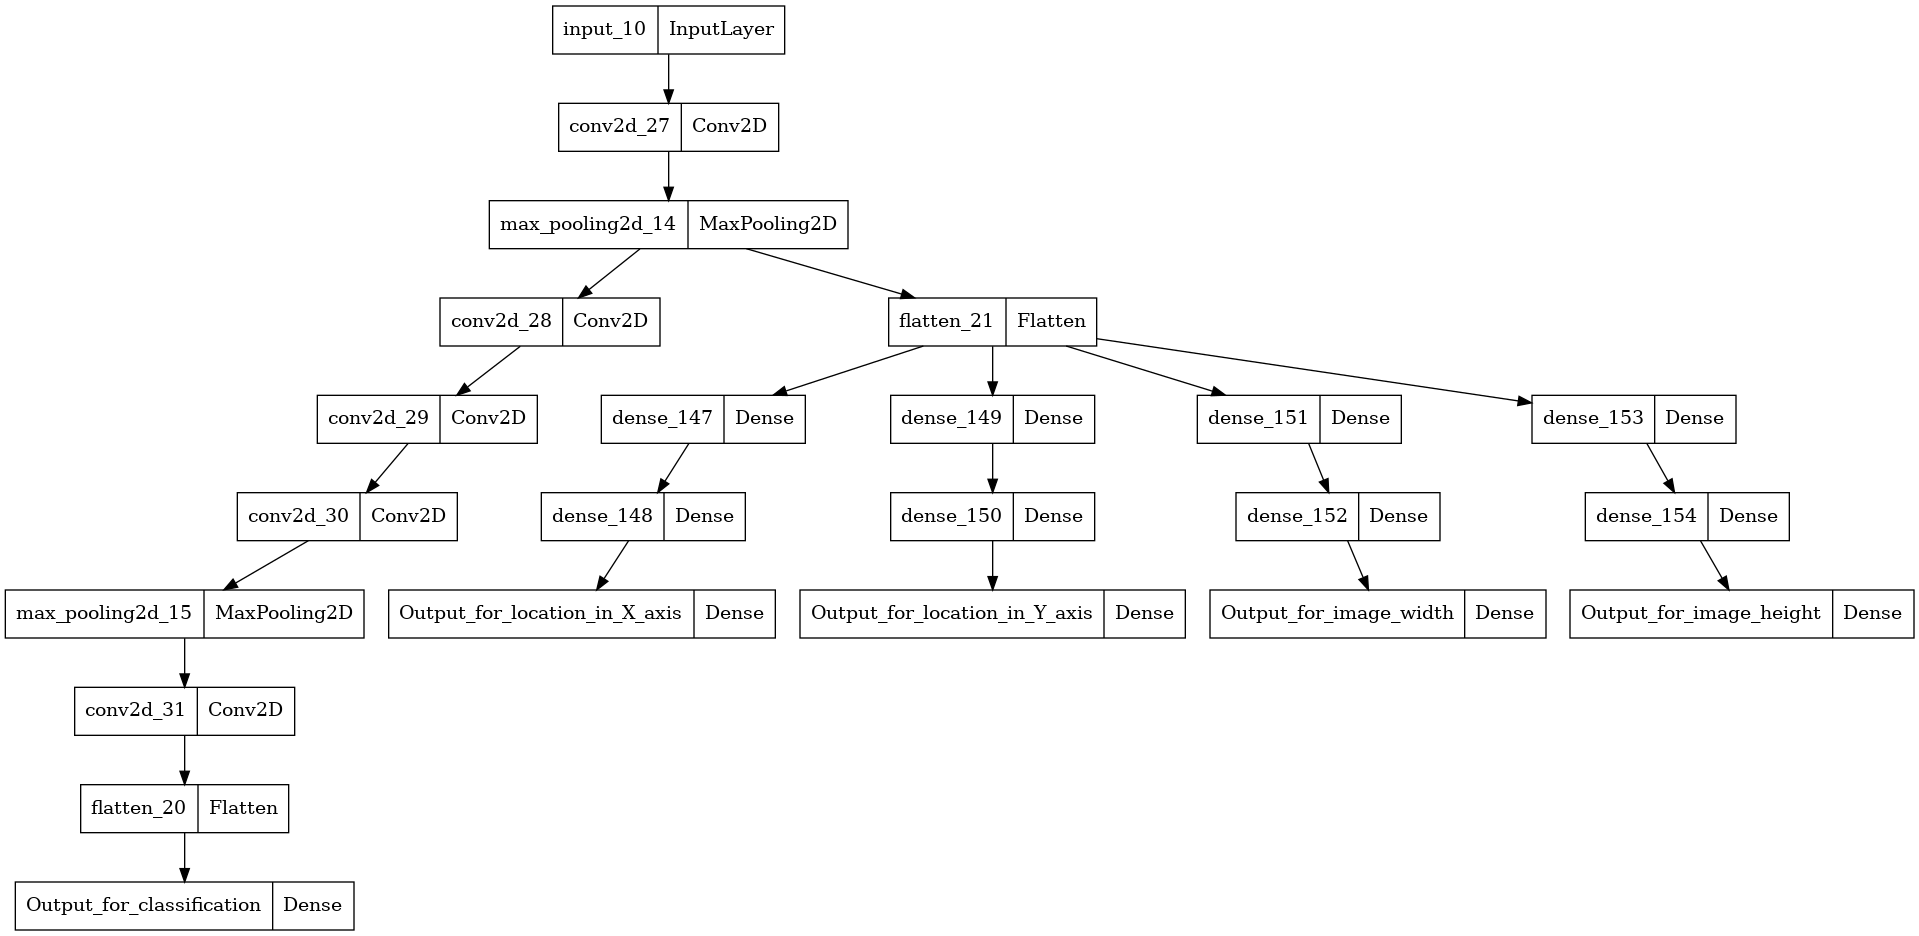

In [163]:
input_layer = layers.Input(shape=(IMG_HEIGHT, IMG_HEIGHT, 1))
gen_part = layers.Conv2D(IMG_HEIGHT, (5,5), input_shape=(None, IMG_HEIGHT, IMG_HEIGHT, 1))(input_layer)
gen_part = layers.MaxPooling2D(pool_size=(3, 3))(gen_part)

# Class of images
class_layer = layers.Conv2D(57, (3,3), activation='relu')(gen_part)
class_layer = layers.Conv2D(55, (3,3), activation='relu')(class_layer)
class_layer = layers.Conv2D(55, (3,3), activation='relu')(class_layer)
class_layer = layers.MaxPooling2D(pool_size=(2, 2))(class_layer)
class_layer = layers.Conv2D(55, (3,3), activation='relu')(class_layer)
class_layer = layers.Flatten()(class_layer)
class_layer = layers.Dense(10, activation='sigmoid', name="Output_for_classification")(class_layer)

other_layer = layers.Flatten()(gen_part)
# X
x_layer = layers.Dense(16, activation='relu')(other_layer)
x_layer = layers.Dense(8, activation='relu')(x_layer)
x_layer = layers.Dense(1, activation='relu', name="Output_for_location_in_X_axis")(x_layer)

# Y
y_layer = layers.Flatten()(gen_part)
y_layer = layers.Dense(16, activation='relu')(other_layer)
y_layer = layers.Dense(8, activation='relu')(y_layer)
y_layer = layers.Dense(1, activation='relu', name="Output_for_location_in_Y_axis")(y_layer)

# width
width_layer = layers.Dense(16, activation='relu')(other_layer)
width_layer = layers.Dense(8, activation='relu')(width_layer)
width_layer = layers.Dense(1, activation='relu', name="Output_for_image_width")(width_layer)

# height
height_layer = layers.Dense(16, activation='relu')(other_layer)
height_layer = layers.Dense(8, activation='relu')(height_layer)
height_layer = layers.Dense(1, activation='relu', name="Output_for_image_height")(height_layer)

model = tf.keras.Model(inputs=input_layer, outputs=[class_layer, x_layer, y_layer, width_layer, height_layer])
model.compile(
    optimizer='Adam',
    loss={
        'Output_for_classification':'CategoricalCrossentropy',
        'Output_for_location_in_X_axis':'MSE',
        'Output_for_location_in_Y_axis':'MSE',
        'Output_for_image_width':'MSE',
        'Output_for_image_height':'MSE'
    },
    metrics={
        'Output_for_classification':'TopKCategoricalAccuracy',
        'Output_for_location_in_X_axis':'MSE',
        'Output_for_location_in_Y_axis':'MSE',
        'Output_for_image_width':'MSE',
        'Output_for_image_height':'MSE'
    }
)
tf.keras.utils.plot_model(model)

In [88]:
checkpoint_path = 'training_hw4/question1_model-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname('HW4_MNIST_train/question1_model.ckpt')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=[cp_callback]
)

Epoch 1/10
2434/2435 [============================>.] - ETA: 0s - loss: 1.3222 - Output_for_classification_loss: 0.6312 - Output_for_location_in_X_axis_loss: 0.1526 - Output_for_location_in_Y_axis_loss: 0.2021 - Output_for_image_width_loss: 0.1248 - Output_for_image_height_loss: 0.2115 - Output_for_classification_top_k_categorical_accuracy: 0.9612 - Output_for_location_in_X_axis_MSE: 0.1526 - Output_for_location_in_Y_axis_MSE: 0.2021 - Output_for_image_width_MSE: 0.1248 - Output_for_image_height_MSE: 0.2115
Epoch 1: saving model to training_hw4/question1_model-0001.ckpt
2435/2435 [==============================] - 36s 14ms/step - loss: 1.3220 - Output_for_classification_loss: 0.6310 - Output_for_location_in_X_axis_loss: 0.1525 - Output_for_location_in_Y_axis_loss: 0.2021 - Output_for_image_width_loss: 0.1248 - Output_for_image_height_loss: 0.2115 - Output_for_classification_top_k_categorical_accuracy: 0.9612 - Output_for_location_in_X_axis_MSE: 0.1525 - Output_for_location_in_Y_axis_MS

## 讀取模型

In [165]:
model.load_weights('training_hw4/question1_model-0010.ckpt')

## 呈現結果

In [89]:
ds = list(valid_ds.take(1))[0]
predict = model.predict(ds[0])

Confusion Matrix

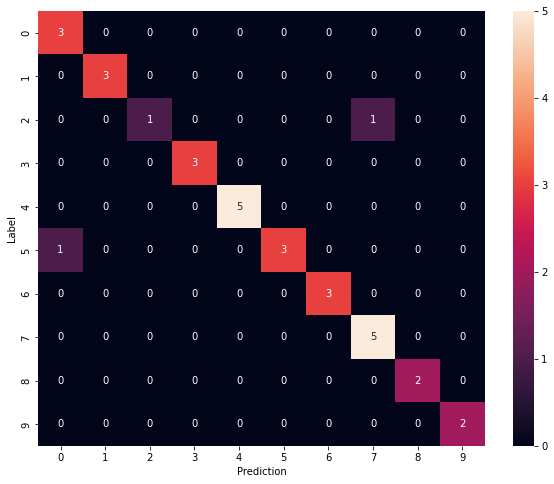

In [166]:
y_true = tf.argmax(ds[1][0], axis=1)
y_pred = tf.argmax(predict[0], axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=range(10),
            yticklabels=range(10),
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Top-1 & top-3 accuracy

In [167]:
print('Top-1 Accuracy: ', end="")
m = tf.metrics.TopKCategoricalAccuracy(k=1)
m.update_state(ds[1][0], predict[0])
print(m.result().numpy())

print('Top-3 Accuracy: ', end="")
m = tf.metrics.TopKCategoricalAccuracy(k=3)
m.update_state(ds[1][0], predict[0])
print(m.result().numpy())

Top-1 Accuracy: 0.9375
Top-3 Accuracy: 1.0


Intersection over Union

In [ ]:
pass

Network Architecture

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 124, 124, 12  3328        ['input_10[0][0]']               
                                8)                                                                
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 41, 41, 128)  0          ['conv2d_27[0][0]']              
 )                                                                                         

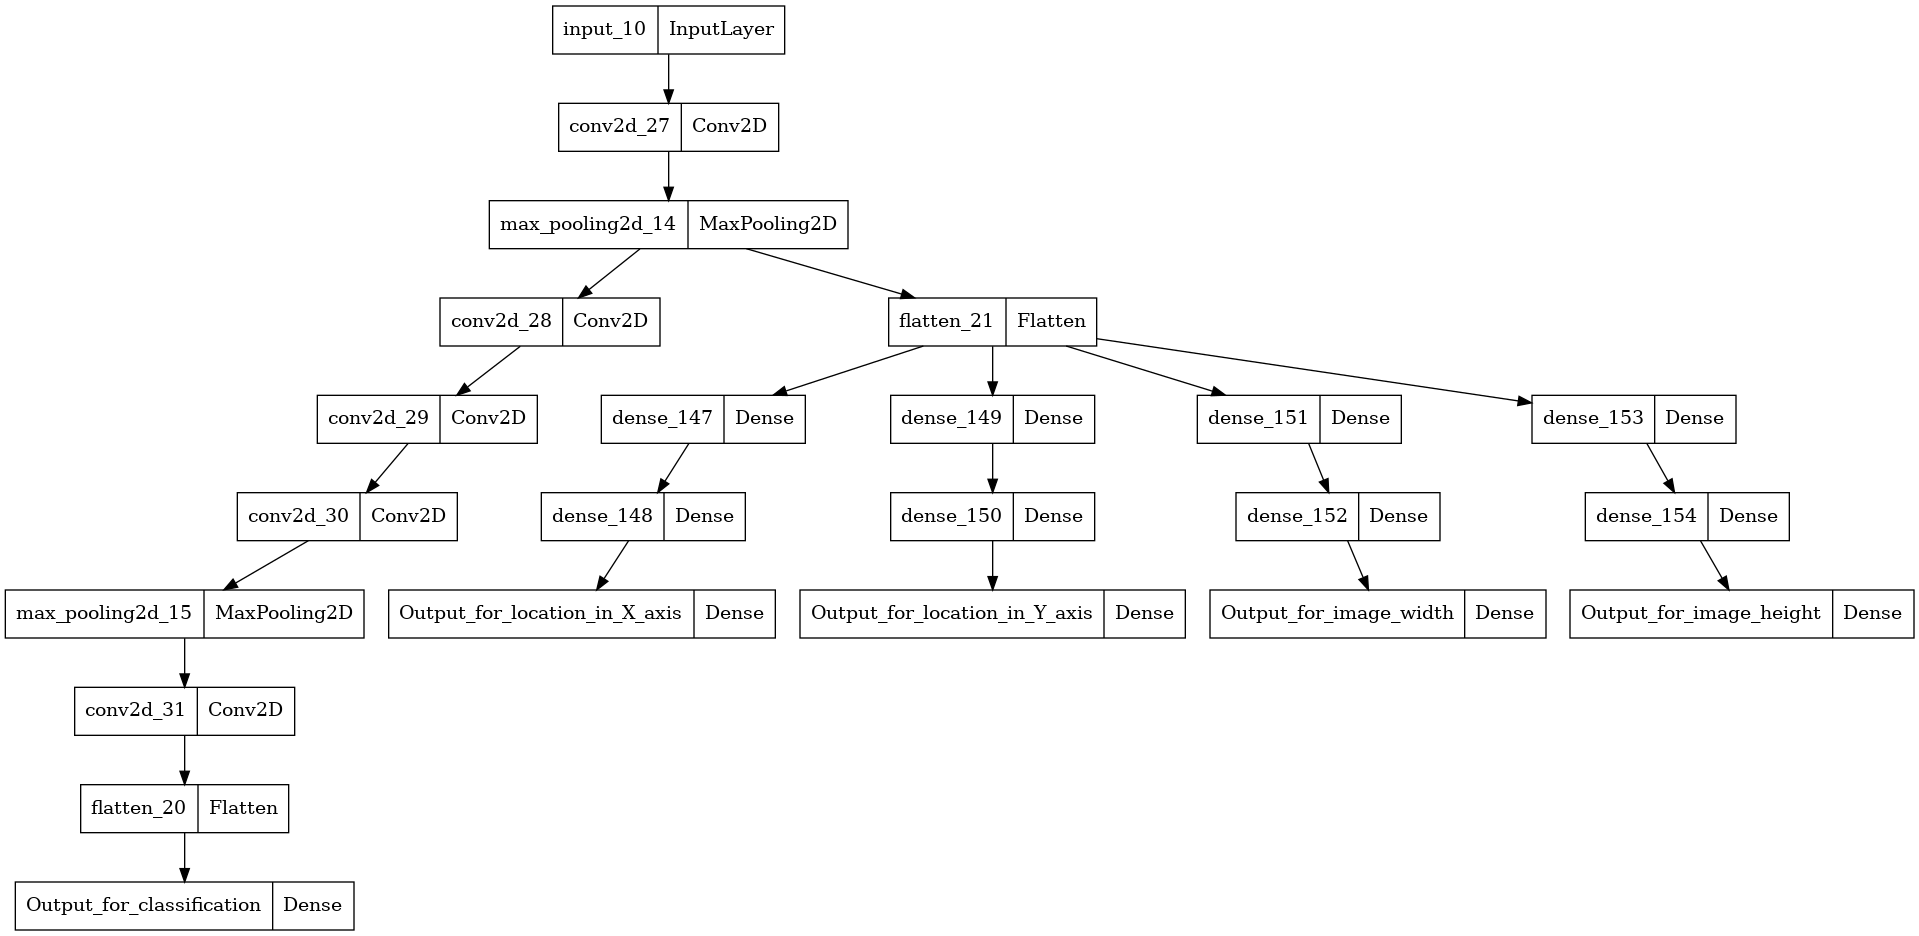

In [168]:
model.summary()
tf.keras.utils.plot_model(model)

測試函式

In [196]:
def load_image_and_run_model(image_path):
    image = tf.io.decode_png(
            tf.io.read_file(image_path),
            channels=1
        )

    image = tf.reshape(image, (1,128,128, 1))

    result = model(image)
    print("Digit: ", tf.argmax(result[0], axis=1))
    print(f"Location: {result[1][0]}, {result[2][0]}")
    print(f"width : {result[3][0]}")
    print(f"height: {result[4][0]}")

In [197]:
load_image_and_run_model('HW4_MNIST_train/4/0000001.png')

Digit:  tf.Tensor([0], shape=(1,), dtype=int64)
Location: [0.], [0.]
width : [0.]
height: [0.]


In [178]:
image = tf.io.decode_png(
    tf.io.read_file('HW4_MNIST_train/4/0000001.png'),
    channels=1
)
image.shape

TensorShape([128, 128, 1])

# Question 2
## 讀取資料集

## 建構模型

建構 Generator

In [157]:
def make_generator_model():
    noise_input = layers.Input(shape=(100,), name='noise_input')
    noise_layer = layers.Dense(1024, use_bias=False)(noise_input)

    one_hot_digit = layers.Input(shape=(10,), name='digit_input')
    digit_layer = layers.Dense(1024, use_bias=False)(one_hot_digit)
    
    size_input = layers.Input(shape=(1,), name='size_input')
    size_layer = layers.Dense(1024, use_bias=False)(size_input)

    main_layer = layers.Multiply()([noise_layer, size_layer])
    main_layer = layers.Multiply()([main_layer, digit_layer])
    main_layer = layers.BatchNormalization()(main_layer)
    main_layer = layers.LeakyReLU()(main_layer)
    
    comb_layer = layers.Reshape((1, 1, 1024))(main_layer)
    comb_layer = layers.Conv2DTranspose(1024, (5, 5), strides=(2, 2), padding='same', use_bias=False)(comb_layer)
    comb_layer = layers.BatchNormalization()(comb_layer)
    comb_layer = layers.LeakyReLU()(comb_layer)
    comb_layer = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(comb_layer)
    comb_layer = layers.BatchNormalization()(comb_layer)
    comb_layer = layers.LeakyReLU()(comb_layer)
    comb_layer = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(comb_layer)
    comb_layer = layers.BatchNormalization()(comb_layer)
    comb_layer = layers.LeakyReLU()(comb_layer)
    comb_layer = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(comb_layer)
    comb_layer = layers.BatchNormalization()(comb_layer)
    comb_layer = layers.LeakyReLU()(comb_layer)

    comb_layer = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(comb_layer)

    return tf.keras.Model(inputs=[noise_input, one_hot_digit, size_input], outputs=comb_layer)

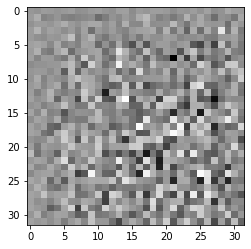

In [158]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator([noise, tf.reshape(tf.one_hot(5, 10), (1,10)), tf.random.normal((1,1))], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [159]:
generator.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_input (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 size_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_144 (Dense)              (None, 1024)         102400      ['noise_input[0][0]']            
                                                                                                  
 dense_146 (Dense)              (None, 1024)         1024        ['size_input[0][0]']             
                                                                                           

建構 Discriminator (使用 Question 1 的模型)

In [125]:
assert model
discriminator = model

## 讀取模型

## 呈現結果